In [1]:
from transformers import BertConfig, BertForMaskedLM, BertModel
import pandas as pd
import os
import random
import numpy as np
import torch
import tqdm
from collections import defaultdict
import pickle
import gc

In [2]:
if not os.path.exists(os.path.join("..", "data", "sequences.pickle")):
    print('Building sequences')
    data_path = os.path.join("..", "data", "data.csv.gz")
    df = pd.read_csv(data_path, compression='gzip')
    grouped = df.groupby('steamid')
    sequences = [list(v) for k, v in tqdm.tqdm(grouped['appid'])]
    with open(os.path.join("..", "data", "sequences.pickle"), 'wb') as f:
        pickle.dump(sequences, f)
    
    del df
    del grouped
    gc.collect();
else:
    print('Loading sequences')
    with open(os.path.join("..", "data", "sequences.pickle"), 'rb') as f:        
        sequences = pickle.load(f)

Loading sequences


In [3]:
num_games = 2691
PAD_TOKEN = num_games
MASK_TOKEN = num_games + 1
CLS_TOKEN = num_games + 2
HIDDEN_SIZE = 256
bert_config = BertConfig(
    vocab_size=num_games+3,
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=4,
    num_attention_heads=4,
    pad_token_id=PAD_TOKEN,
)

MAXLEN = 100

In [4]:
def batch_data(batch_size):
    random.shuffle(sequences)
    for i in range(0, len(sequences), batch_size):
        batch_sequences = sequences[i:i+batch_size]
        splits = []
        for i, seq in enumerate(batch_sequences):
            split = int(len(seq)*random.uniform(0.5, 0.8))

            if split>MAXLEN:
                split = MAXLEN
            splits.append(split)

        biggest_len = max(splits)
        mb_size=len(batch_sequences)        
        mb_data = np.empty((mb_size, biggest_len+1), dtype=np.int64)
        positive = np.zeros((mb_size, num_games), dtype=np.bool)
        negative = np.ones((mb_size, num_games), dtype=np.bool)

        for i, seq in enumerate(batch_sequences):
            random.shuffle(seq)
            split = splits[i]

            mb_data[i, 1:1+split] = seq[:split]
            mb_data[i, 1+split:] = PAD_TOKEN            
            positive[i, seq[split:]] = True
            negative[i, seq] = False
        
        mb_data[:, 0] = CLS_TOKEN
        yield torch.tensor(mb_data).cuda(), torch.tensor(positive).cuda(), torch.tensor(negative).cuda()

In [5]:
class TransformerModel(torch.nn.Module):
    def __init__(self, bert_config):
        super().__init__()
        self.bert_model = BertModel(bert_config)
        self.dense = torch.nn.Linear(HIDDEN_SIZE, num_games)

    def forward(self, x, position_ids=None):
        embedding = self.bert_model(x, position_ids=position_ids).pooler_output
        return self.dense(embedding)        

In [6]:
model = TransformerModel(bert_config).cuda()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [8]:
losses = []
BATCH_SIZE = 200
for e in range(10):
    pbar = tqdm.tqdm(batch_data(BATCH_SIZE), total=len(sequences)//BATCH_SIZE)
    for x, positive, negative in pbar:
        optimizer.zero_grad()
        output = model(x, position_ids=torch.zeros_like(x))
        bpr_loss = 0
        for i in range(x.shape[0]):
            pos = output[0][positive[0]]
            neg = output[0][negative[0]]
            x_ij = (pos.unsqueeze(-1)-neg)
            bpr_loss += -torch.log(torch.sigmoid(x_ij)).sum()

        bpr_loss = bpr_loss/x.shape[0]
        losses.append(bpr_loss.item())
        bpr_loss.backward()
        pbar.set_description(f"loss: {np.mean(losses[-50:]):.6f}")
        optimizer.step()

    torch.save(model.state_dict(), '../model/model.bin')

loss: 5117.468980: : 36752it [5:28:17,  1.87it/s]
loss: 7291.079051: : 36752it [5:41:29,  1.79it/s]
loss: 5651.627019:   0%|          | 9/36751 [00:12<14:28:50,  1.42s/it]


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

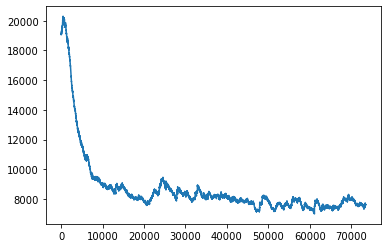

In [15]:
y = [losses[0]]
a = 0.0005
for loss in losses:
    y.append(y[-1]*(1-a)+loss*a)

plt.plot(y)

In [71]:
my_games = ['700330', '322330', '992490', '730', '211820', '218620', '578080', '221100', '367520', '33930', '1097150', '570', '8930', '4000', '601150', '391540', '644930', '1172470', '438100', '91310', '57400', '250760', '200260', '286160', '607050', '208140', '1200', '739630', '247080', '247350', '222880', '202090', '386940', '481510', '304930', '208090', '877200', '219640', '224260', '736260', '367540', '40400', '584400', '250050', '238960', '222750', '323850', '466240', '219890', '16450', '440', '230980', '239070', '209080', '265630', '239350', '630', '312530', '374320', '32800', '1289310', '1520', '224760', '208670', '250580', '231160', '113020', '223470', '804270', '493900', '1280', '620', '113400', '223220', '1249200', '261510', '488310', '368730', '1276100', '272350', '340000', '425410', '518580', '510050', '804490', '437570', '212800', '457550', '214770', '341800', '1089130', '225280', '207140', '373770', '695970', '224580', '813820', '40420', '252130', '33910', '241640', '247020', '386010', '606180', '318600', '418180', '1229740', '1009850', '98800', '269710', '916840', '1555710', '1248270', '207430', '698780', '578210', '274310', '553880', '219540', '35140', '231040', '346010', '291550', '235584', '205790', '236090', '21100', '984210', '365450', '408710', '435400', '280180', '587430', '385710', '690810', '1230', '394310', '314410', '436320', '878760', '235580', '674940', '203160', '359580', '429881', '230410']

In [94]:
appids = pd.read_csv('../data/appids.csv')
game_info = pd.read_csv('../data/app_id_info.csv')

In [73]:
my_games_subset = [g for g in games if int(g) in set(appids['appid'])]

In [74]:
appids_dict = appids.groupby('appid').apply(lambda g:g['gameid'].values[0]).to_dict()

In [75]:
games_sequence = [CLS_TOKEN]+[appids_dict[int(g)] for g in games]
games_sequence = np.array([games_sequence], dtype=np.int64)

In [76]:
game_tensor = torch.tensor(games_sequence).cuda()

In [77]:
[pred] = model(game_tensor).detach().cpu().numpy()
pred[games_sequence[0, 1:]]=-np.Infinity

# Top 20 recommendations

In [106]:
top = pred.argsort()[::-1][:20]
recommendations = appids[appids['gameid'].isin(top)].sort_values("gameid", key=lambda x:x.apply(lambda g:np.where(top==g)))
pd.merge(recommendations, game_info, on='appid')

,appid,gameid,Title,Type,Price,Release_Date,Rating,Required_Age,Is_Multiplayer
0,72850,2401,The Elder Scrolls V: Skyrim,game,19.99,2011-11-10 00:00:00,94,17,0
1,550,228,Left 4 Dead 2,game,19.99,2009-11-16 00:00:00,89,0,1
2,400,176,Portal,game,9.99,2007-10-10 00:00:00,90,0,0
3,105600,2396,Terraria,game,9.99,2011-05-16 00:00:00,83,0,1
4,43110,776,Metro 2033,game,14.99,2010-03-15 00:00:00,81,0,0
5,55230,1995,Saints Row: The Third,game,14.99,2011-11-14 00:00:00,84,17,0
6,42910,714,Magicka,game,9.99,2011-01-25 00:00:00,74,0,1
7,4560,1508,Company of Heroes,game,19.99,2007-07-17 00:00:00,93,17,1
8,22380,1967,Fallout: New Vegas,game,9.99,2010-10-19 00:00:00,84,16,0
9,9340,414,Company of Heroes: Opposing Fronts,game,19.99,2007-09-24 00:00:00,87,18,1


# 20 least recommended

In [107]:
bottom = pred.argsort()[len(games)+2:len(games)+22]
recommendations = appids[appids['gameid'].isin(bottom)].sort_values("gameid", key=lambda x:x.apply(lambda g:np.where(bottom==g)))
pd.merge(recommendations, game_info, on='appid')

,appid,gameid,Title,Type,Price,Release_Date,Rating,Required_Age,Is_Multiplayer
0,95700,1845,The Cat and the Coup,game,0.00,2011-06-15 00:00:00,-1,0,0
1,222520,497,Champions of Regnum,game,0.00,2013-02-27 00:00:00,-1,0,0
2,249930,1357,A-Train 8,game,19.99,2013-09-18 00:00:00,-1,0,0
3,238910,498,Bionic Dues,game,9.99,2013-10-08 00:00:00,71,0,0
4,29150,1518,Mightier,demo,0.00,2009-03-19 00:00:00,-1,0,0
5,236490,2324,Hexodius,game,9.99,2013-06-21 00:00:00,47,0,0
6,250400,1545,How to Survive,game,14.99,2014-08-29 00:00:00,60,0,1
7,243040,1813,Startopia,game,6.99,2013-10-10 00:00:00,86,13,0
8,248510,958,Dominions 3: The Awakening,game,19.99,2013-09-10 00:00:00,82,0,1
9,251410,1868,Dark Matter,game,9.99,2013-10-17 00:00:00,-1,0,0


In [108]:
recommendations

,appid,gameid
165,24950,165
1845,95700,1845
497,222520,497
878,215490,878
1357,249930,1357
498,238910,498
1518,29150,1518
1629,13120,1629
2324,236490,2324
1545,250400,1545
